In [1]:
# %env XLA_PYTHON_CLIENT_PREALLOCATE=false


In [2]:

%load_ext autoreload
%autoreload 2
import sys
import os
import glob
import random
from collections import defaultdict
from pathlib import Path

from IPython.display import display

import pandas as pd

import jax
jax.config.update('jax_platform_name', 'cpu')
# jax.config.update('jax_log_compiles', True)
# jax.config.update("jax_debug_nans", True)
# jax.config.update("jax_enable_x64", True)

In [3]:


sys.path.append("../..")

from lib import utils as U
from lib.ehr import load_dataset, load_dataset_scheme, load_dataset_config, Dataset
from lib.ehr.interface import Patients, InterfaceConfig
from lib.ehr.concepts import DemographicVectorConfig, LeadingObservableConfig


## Load Dataset

In [4]:
tag = 'M4ICU'
PATH = f'{os.environ.get("HOME")}/GP/ehr-data/mimic4icu-cohort'
sample = 15000
cache =  f'cached_inteface/patients_{tag}_{sample or ""}'
dataset_config = load_dataset_config(tag, 
                                     sample=sample,
                                     path=PATH)

In [5]:
import json
dataset_scheme = load_dataset_scheme(tag)
interface_schem_options = dataset_scheme.supported_target_scheme_options
print(json.dumps(interface_schem_options, sort_keys=True, indent=4))

{
    "dx": [
        "DxICD10",
        "DxICD9",
        "DxFlatCCS",
        "DxCCS"
    ],
    "ethnicity": [
        "MIMIC4Eth32",
        "MIMIC4Eth5"
    ],
    "gender": [
        "Gender"
    ],
    "int_input": [
        "MIMICInput",
        "MIMICInputGroups"
    ],
    "int_proc": [
        "MIMICProcedures",
        "MIMICProcedureGroups"
    ],
    "obs": [
        "MIMICObservables"
    ],
    "outcome": [
        "dx_flatccs_filter_v1",
        "dx_icd9_filter_v1",
        "dx_flatccs_mlhc_groups",
        "dx_icd9_filter_v3_groups",
        "dx_icd9_filter_v2_groups"
    ]
}


In [6]:

# Demographic vector attributes
demographic_vector_conf = DemographicVectorConfig(
    age=False, 
    gender=False, 
    ethnicity=False
)

# Leading 
leading_AKI = LeadingObservableConfig(leading_hours=tuple(6 * i for i in range(1, 13)),
                                      window_aggregate='max',
                                      scheme=dataset_scheme.obs,
                                      index=42)

In [7]:
interface_scheme = dataset_scheme.make_target_scheme_config(dx='DxICD9',
                                                            outcome='dx_icd9_filter_v3_groups',
                                                            ethnicity='MIMIC4Eth5')
interface_config = InterfaceConfig(scheme=interface_scheme,
                                   dataset_scheme=dataset_scheme,
                                   demographic_vector=demographic_vector_conf,
                                   leading_observable=leading_AKI,
                                   cache=cache)

In [8]:
def dataset_gen(dataset_config):
    dataset = load_dataset(config=dataset_config)
    # Use training-split for fitting the outlier_remover and the scalers.
    splits = dataset.random_splits([0.8, 0.9], random_seed=42, balanced='admissions')
    # Outlier removal
    outlier_remover = dataset.fit_outlier_remover(splits[0])
    dataset = dataset.remove_outliers(outlier_remover)

    # Scale
    scalers = dataset.fit_scalers(splits[0])
    return dataset.apply_scalers(scalers)
        

In [ ]:
m4patients = Patients.try_load_cached(interface_config,
                                      dataset_config=dataset_config,
                                      dataset_generator=dataset_gen,
                                      num_workers=8)

/home/asem/GP/ICE-NODE/notebooks/mimic_icu/../../lib/ehr/ds_mimic4.py:261: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  dob = anchor_date + anchor_age
/home/asem/GP/ICE-NODE/notebooks/mimic_icu/../../lib/ehr/concepts.py:48: RuntimeWarning: All-NaN slice encountered
  return func(x, axis)


In [ ]:
# import equinox as eqx
# # Delete heavy loads
# m4patients = eqx.tree_at(lambda x: x.subjects, m4patients, {})
# m4patients = eqx.tree_at(lambda x: x.dataset, m4patients, None)

## Load Model

In [ ]:
from lib.ml import InpatientExperiment
from lib import Config, Module

In [ ]:
experiments_dir = f'{os.environ.get("HOME")}/GP/ehr-data/m4icu_out/backup_override/sigmo_dtw_B32_icenode'
# experiments_dir = f'{os.environ.get("HOME")}/GP/ehr-data/m4icu_out/backup_override/sigmo_mse_B32_icenode'

# experiments_dir = f'{os.environ.get("HOME")}/GP/ehr-data/m4icu_out/mono_mse_icenode'
# experiments_dir = f'{os.environ.get("HOME")}/GP/ehr-data/m4icu_out/sigmo_dtw_icenode'
# experiments_dir = f'{os.environ.get("HOME")}/GP/ehr-data/m4icu_out/sigmo_mse_icenode'

params_file = 'step9293.eqx'
# params_file = 'step8260.eqx'

# params_file = 'step3355.eqx'
# params_file = 'step7227.eqx'
# params_file = 'step2839.eqx'

experiment_config = U.load_config(f'{experiments_dir}/config.json')
experiment_config = Config.from_dict(experiment_config)
experiment = InpatientExperiment(config=experiment_config)

In [ ]:
splits = experiment.load_splits(m4patients.dataset)
model = experiment.load_model(m4patients)

In [ ]:
[len(s) for s in splits]

In [ ]:
metrics = experiment.load_metrics(m4patients, splits)

In [ ]:
model = model.load_params_from_archive(f'{experiments_dir}/params.zip', params_file)


In [ ]:
test_split = m4patients.device_batch(splits[2])

In [ ]:
predictions = model.batch_predict(test_split)

In [ ]:
predictions.save(f'{experiments_dir}/predictions_{params_file}')

In [ ]:
from lib.ehr import Predictions
predictions = Predictions.load(f'{experiments_dir}/predictions_{params_file}')

In [ ]:
predictions._defragment_observables()
predictions.save(f'{experiments_dir}/defrag_predictions_{params_file}')

In [16]:
from lib.ehr import Predictions
predictions = Predictions.load(f'{experiments_dir}/defrag_predictions_{params_file}')

In [ ]:
from lib.metric import AKISegmentedAdmissionMetric, AKISegmentedAdmissionConfig

In [ ]:
aki_metric = AKISegmentedAdmissionMetric(patients=m4patients, 
                                         config=AKISegmentedAdmissionConfig(stable_window=72))

In [ ]:
res,segmented_AKI,segmented_AKI_byclass = aki_metric(predictions)

In [ ]:
res

In [29]:
segmented_AKI_byclass.keys()

dict_keys(['stable', 'first_AKI_pre_emergence', 'AKI', 'AKI_recovery', 'AKI_pre_emergence'])

In [30]:
segmented_AKI['28669544']

[{'i1': 0,
  'i2': 21,
  'admission_id': '28669544',
  'time': array([ 0.6666667,  2.6666667,  3.6666667,  6.6666665,  7.6666665,
          8.666667 ,  9.666667 , 10.666667 , 11.666667 , 12.666667 ,
         13.666667 , 14.666667 , 15.666667 , 16.666666 , 17.666666 ,
         18.666666 , 19.666666 , 20.666666 , 21.666666 , 22.666666 ,
         23.666666 ], dtype=float32),
  'next_interval_time': 24.666666,
  'aki_label': 0.0,
  'aki_preds': array([0.37511462, 0.2644776 , 0.2306558 , 0.20567529, 0.21733357,
         0.24723588, 0.26174635, 0.25366244, 0.23500448, 0.24214733,
         0.24125636, 0.24461685, 0.21619093, 0.22181584, 0.19816257,
         0.18689269, 0.18053725, 0.19344859, 0.18704256, 0.19382884,
         0.1911887 ], dtype=float32),
  'class': 'first_AKI_pre_emergence'},
 {'i1': 21,
  'i2': 63,
  'admission_id': '28669544',
  'time': array([24.666666, 25.666666, 26.666666, 27.666666, 28.666666, 29.666666,
         30.666666, 31.666666, 32.666668, 33.666668, 34.666668, 35.

In [60]:
segmented_AKI_byclass['AKI_pre_emergence'][3]

{'i1': 169,
 'i2': 205,
 'admission_id': '27896316',
 'time': array([169.28334, 170.28334, 171.28334, 172.28334, 173.28334, 174.28334,
        175.28334, 176.28334, 177.28334, 178.28334, 179.28334, 180.28334,
        181.28334, 182.28334, 183.28334, 184.28334, 185.28334, 186.28334,
        187.28334, 188.28334, 189.28334, 190.28334, 191.28334, 192.28334,
        193.28334, 194.28334, 195.28334, 196.28334, 197.28334, 198.28334,
        199.28334, 200.28334, 201.28334, 202.28334, 203.28334, 204.28334],
       dtype=float32),
 'next_interval_time': 205.28334,
 'aki_label': 0.0,
 'aki_preds': array([0.50052106, 0.4912325 , 0.44365042, 0.4406414 , 0.40044758,
        0.40094587, 0.39979115, 0.3958742 , 0.4031109 , 0.37977692,
        0.39408273, 0.41398734, 0.39114982, 0.38256338, 0.33789274,
        0.34029925, 0.34548232, 0.36336356, 0.35727477, 0.31635088,
        0.3078018 , 0.32867616, 0.32648912, 0.30685326, 0.26679882,
        0.2584718 , 0.28765523, 0.3056373 , 0.2796724 , 0.2630123

In [63]:
# [sid for sid in predictions if '27896316' in predictions[sid]]

In [64]:
import numpy as np
# pred = predictions['14139649']['28669544']
pred = predictions['14316710']['27896316' ]
aki_now = pred.admission.observables.value[:, 42]
lobs_gt = pred.admission.leading_observable
lobs = pred.leading_observable
aki_t = lobs.time
aki_preds = np.max(lobs.value, axis=1)
aki_mask = lobs.mask.max(axis=1) > 0
aki_gt = np.max(lobs_gt.value, axis=1)

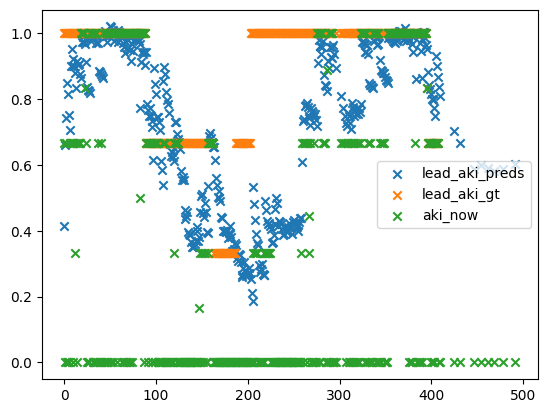

In [65]:
import matplotlib.pyplot as plt

# plot lines 
plt.scatter(aki_t, aki_preds, label = "lead_aki_preds", marker="x") 
plt.scatter(aki_t, aki_gt, label = "lead_aki_gt", marker="x") 
plt.scatter(aki_t, aki_now, label = "aki_now", marker="x") 

plt.legend() 
plt.show()

In [57]:
aki_now

Array([0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.6665, 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 1.    , 1.    , 1.    , 1.    ,
       1.    , 1.    , 1.    , 1.    , 1.    , 0.    , 1.    , 1.    ,
       1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.3333, 0.    , 0.    , 0.    ,
       0.3333, 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    ], dtype=float16)

In [56]:
segmented_AKI['28669544']

[{'i1': 0,
  'i2': 21,
  'admission_id': '28669544',
  'time': array([ 0.6666667,  2.6666667,  3.6666667,  6.6666665,  7.6666665,
          8.666667 ,  9.666667 , 10.666667 , 11.666667 , 12.666667 ,
         13.666667 , 14.666667 , 15.666667 , 16.666666 , 17.666666 ,
         18.666666 , 19.666666 , 20.666666 , 21.666666 , 22.666666 ,
         23.666666 ], dtype=float32),
  'next_interval_time': 24.666666,
  'aki_label': 0.0,
  'aki_preds': array([0.37511462, 0.2644776 , 0.2306558 , 0.20567529, 0.21733357,
         0.24723588, 0.26174635, 0.25366244, 0.23500448, 0.24214733,
         0.24125636, 0.24461685, 0.21619093, 0.22181584, 0.19816257,
         0.18689269, 0.18053725, 0.19344859, 0.18704256, 0.19382884,
         0.1911887 ], dtype=float32),
  'class': 'first_AKI_pre_emergence'},
 {'i1': 21,
  'i2': 63,
  'admission_id': '28669544',
  'time': array([24.666666, 25.666666, 26.666666, 27.666666, 28.666666, 29.666666,
         30.666666, 31.666666, 32.666668, 33.666668, 34.666668, 35.

In [21]:
import pandas as pd

In [38]:
val_df = pd.read_csv(f'{experiments_dir}/val_evals.csv.gz', index_col=[0])
trn_df = pd.read_csv(f'{experiments_dir}/train_evals.csv.gz', index_col=[0])

In [39]:
val_df

,CodeAUC.I0C140.auc,CodeAUC.I0C140.n,CodeAUC.I1C140.0.auc,CodeAUC.I1C140.0.n,CodeAUC.I2C140.1.auc,CodeAUC.I2C140.1.n,CodeAUC.I3C140.3.auc,CodeAUC.I3C140.3.n,CodeAUC.I4C140.4.auc,CodeAUC.I4C140.4.n,...,LeadingObsTrends.min(rms),LeadingObsTrends.std(rms),LeadingObsTrends.count(rms),LeadingObsTrends.mean(mse),LeadingObsTrends.median(mse),LeadingObsTrends.max(mse),LeadingObsTrends.min(mse),LeadingObsTrends.std(mse),LeadingObsTrends.count(mse),date_time
1032,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,...,0.181447,0.021695,12,0.055579,0.058744,0.065963,0.032923,0.009619,12,2023-09-26 09:28:34.325422
2065,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,...,0.174278,0.021991,12,0.053333,0.056488,0.063279,0.030373,0.009480,12,2023-10-03 13:04:34.668361
3097,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,...,0.170651,0.022332,12,0.051848,0.054988,0.061908,0.029122,0.009490,12,2023-10-07 05:54:14.337119
4130,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,...,0.170718,0.022287,12,0.052137,0.055688,0.061459,0.029145,0.009463,12,2023-10-11 01:49:39.229448
5162,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,...,0.167582,0.023122,12,0.051898,0.055221,0.061833,0.028084,0.009767,12,2023-10-15 02:18:02.273523
6195,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,...,0.174156,0.024670,12,0.056425,0.059338,0.068942,0.030330,0.010913,12,2023-10-19 03:51:11.674501
7227,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,...,0.168224,0.024282,12,0.052957,0.056929,0.063095,0.028299,0.010350,12,2023-10-23 06:46:22.340168
8260,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,...,0.168176,0.023521,12,0.052608,0.055952,0.062997,0.028283,0.010000,12,2023-10-27 10:49:37.187119


In [60]:
obs_cols = [c for c in val_df.columns if 'obs' in c]
lead_cols = [c for c in val_df.columns if 'lead' in c]
dx_cols = [c for c in val_df.columns if 'dx' in c]
obs_cols, lead_cols, dx_cols

(['LossMetric.obs_mae', 'LossMetric.obs_mse', 'LossMetric.obs_rms'],
 ['LossMetric.lead_mae',
  'LossMetric.lead_mse',
  'LossMetric.lead_rms',
  'LossMetric.lead_softdtw(0.1)'],
 ['LossMetric.dx_allpairs_exp_rank',
  'LossMetric.dx_allpairs_hard_rank',
  'LossMetric.dx_allpairs_sigmoid_rank',
  'LossMetric.dx_balanced_focal_bce',
  'LossMetric.dx_balanced_focal_softmax_bce',
  'LossMetric.dx_softmax_bce'])

In [61]:
trn_obs_df = trn_df[obs_cols + lead_cols + dx_cols]
val_obs_df = val_df[obs_cols + lead_cols + dx_cols]


In [62]:
trn_obs_df

,LossMetric.obs_mae,LossMetric.obs_mse,LossMetric.obs_rms,LossMetric.lead_mae,LossMetric.lead_mse,LossMetric.lead_rms,LossMetric.lead_softdtw(0.1),LossMetric.dx_allpairs_exp_rank,LossMetric.dx_allpairs_hard_rank,LossMetric.dx_allpairs_sigmoid_rank,LossMetric.dx_balanced_focal_bce,LossMetric.dx_balanced_focal_softmax_bce,LossMetric.dx_softmax_bce
1032,0.070090,0.015749,0.125496,0.022218,0.009606,0.023321,-0.001852,0.050246,0.000593,0.031898,0.000045,0.001756,0.009579
2065,0.066221,0.016120,0.126965,0.016518,0.005024,0.017793,-0.061927,0.168330,0.003170,0.061338,0.000056,0.001453,0.007338
3097,0.054921,0.010687,0.103376,0.012072,0.002718,0.012874,-0.099748,0.039477,0.000417,0.024594,0.000043,0.002258,0.005919
4130,0.059365,0.012239,0.110629,0.013661,0.003923,0.015085,-0.081796,0.085807,0.001449,0.043979,0.000047,0.001474,0.005368
5162,0.065916,0.014452,0.120215,0.014069,0.003828,0.015156,-0.081824,0.133820,0.002278,0.053662,0.000065,0.002187,0.012566
6195,0.065847,0.012777,0.113034,0.009709,0.003746,0.010390,-0.091249,0.046658,0.000673,0.025218,0.000043,0.002196,0.008504
7227,0.058848,0.010710,0.103491,0.011689,0.003538,0.012529,-0.090507,0.126430,0.002100,0.048736,0.000056,0.001747,0.011317
8260,0.062345,0.012545,0.112006,0.013463,0.003831,0.014756,-0.082915,0.099706,0.001653,0.038364,0.000051,0.001774,0.013419


In [43]:
val_obs_df

,LossMetric.obs_mae,LossMetric.obs_mse,LossMetric.obs_rms
1032,0.071072,0.016635,0.128977
2065,0.066020,0.014598,0.120821
3097,0.063832,0.014037,0.118476
4130,0.063356,0.013826,0.117585
5162,0.061914,0.013456,0.115998
6195,0.061749,0.013519,0.116270
7227,0.060684,0.013244,0.115081
8260,0.060478,0.012963,0.113856


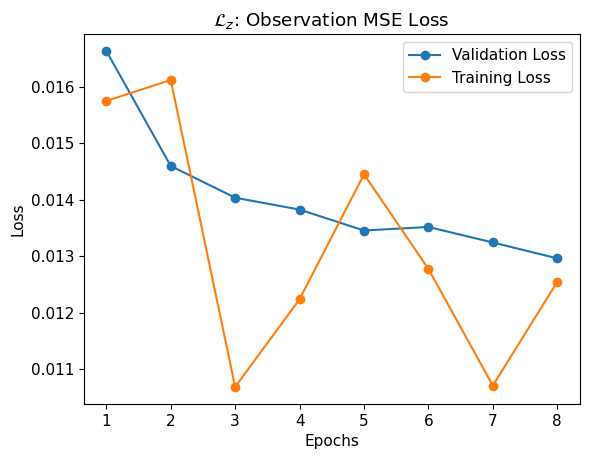

In [81]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams.update({'font.size': 11})

epochs = np.arange(len(val_obs_df)) + 1

# plot lines 
plt.plot(epochs, val_obs_df['LossMetric.obs_mse'].values, label = "Validation Loss", marker='o') 
plt.plot(epochs, trn_obs_df['LossMetric.obs_mse'].values, label = "Training Loss", marker='o') 

plt.title('$\mathcal{L}_z$: Observation MSE Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

current_figure = plt.gcf()
current_figure.savefig(f'{experiments_dir}/obs_loss.pdf', bbox_inches='tight')

plt.legend() 
plt.show()

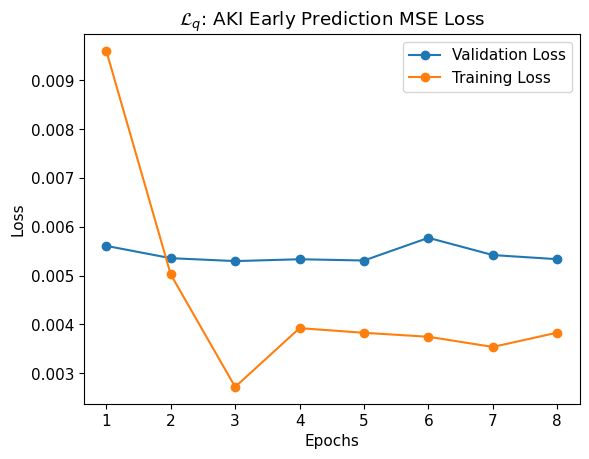

In [82]:
# plot lines 
plt.plot(epochs, val_obs_df['LossMetric.lead_mse'].values, label = "Validation Loss", marker='o') 
plt.plot(epochs, trn_obs_df['LossMetric.lead_mse'].values, label = "Training Loss", marker='o') 

plt.title('$\mathcal{L}_q$: AKI Early Prediction MSE Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')


current_figure = plt.gcf()
current_figure.savefig(f'{experiments_dir}/lead_loss.pdf', bbox_inches='tight')

plt.legend() 
plt.show()

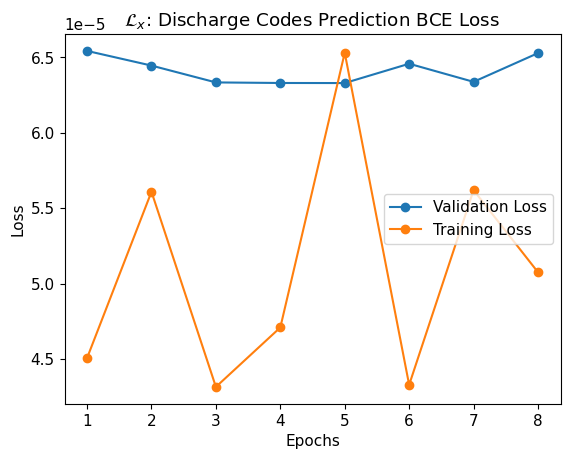

In [83]:
# plot lines 
plt.plot(epochs, val_obs_df['LossMetric.dx_balanced_focal_bce'].values, label = "Validation Loss", marker='o') 
plt.plot(epochs, trn_obs_df['LossMetric.dx_balanced_focal_bce'].values, label = "Training Loss", marker='o') 

plt.title('$\mathcal{L}_x$: Discharge Codes Prediction BCE Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')


current_figure = plt.gcf()
current_figure.savefig(f'{experiments_dir}/dx_loss.pdf', bbox_inches='tight')


plt.legend() 
plt.show()

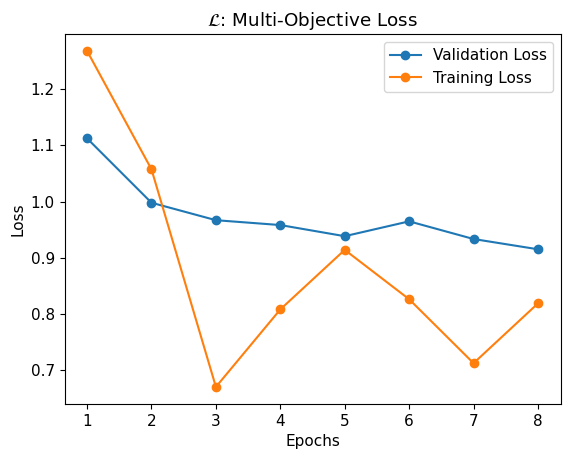

In [84]:
# plot lines 
val_loss = 50 * val_obs_df['LossMetric.obs_mse'] + 50 * val_obs_df['LossMetric.lead_mse'] +  val_obs_df['LossMetric.dx_balanced_focal_bce']
trn_loss = 50 * trn_obs_df['LossMetric.obs_mse'] + 50 * trn_obs_df['LossMetric.lead_mse'] +  trn_obs_df['LossMetric.dx_balanced_focal_bce']

plt.plot(epochs, val_loss.values, label = "Validation Loss", marker='o') 
plt.plot(epochs, trn_loss.values, label = "Training Loss", marker='o') 

plt.title('$\mathcal{L}$: Multi-Objective Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')


current_figure = plt.gcf()
current_figure.savefig(f'{experiments_dir}/loss.pdf', bbox_inches='tight')


plt.legend() 
plt.show()

In [88]:
first_emergence = {k:v for k,v in res.items() if k.startswith('first')}

In [92]:
first_emergence = {k.split('_')[-1]: v for k,v in first_emergence.items()}

In [94]:
fem_auc_df = pd.DataFrame(first_emergence, index=[0])

In [95]:
print(fem_auc_df.to_latex())

\begin{tabular}{lrrrrrrrrrrrr}
\toprule
 & 1-72 & 6-72 & 12-72 & 18-72 & 24-72 & 30-72 & 36-72 & 42-72 & 48-72 & 54-72 & 60-72 & 66-72 \\
\midrule
0 & 0.620599 & 0.593415 & 0.561544 & 0.535354 & 0.511923 & 0.494267 & 0.477539 & 0.463883 & 0.459320 & 0.460780 & 0.462149 & 0.448579 \\
\bottomrule
\end{tabular}

